In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utilsFashionmnist import mnist
import numpy as np

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 8]


In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [3]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-3, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = F.relu(self.fc3(x))
        #x = F.hardshrink(self.fc32(x))
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
def train(epoch, models, train_loss_plot):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
        #train_loss_plot[epoch-1] = ['{:.6f}'.format(m._loss.item()) for m in models]
        train_loss_plot[epoch-1] = [m._loss.item() for m in models]
        print(line + losses)
    return train_loss_plot


In [5]:
models = [Net(True, True)]

In [6]:
def test(models, loader, epoch, test_loss):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)
    
    test_loss = [0]*len(models)
    correct = [0]*len(models)
    
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
    correct_pct = [100. * c / test_size for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    test_loss_plot[epoch-1] = test_loss[0]
    
    print(report)
    return test_loss_plot

In [7]:
epochs_number = 40
train_loss_plot = [0]*len(models)*epochs_number
test_loss_plot = [0]*len(models)*epochs_number
for epoch in range(1, epochs_number+1):
    for model in models:
        model.train()
        train_loss_plot = train(epoch, models, train_loss_plot)
    for model in models:
        model.eval()
        test_loss_plot = test(models, valid_loader, epoch,  test_loss_plot)

Train Epoch: 1 [0/50000 (0%)]	Losses 0: 2.306055
Train Epoch: 1 [10000/50000 (20%)]	Losses 0: 0.163038
Train Epoch: 1 [20000/50000 (40%)]	Losses 0: 0.370961
Train Epoch: 1 [30000/50000 (60%)]	Losses 0: 0.069330
Train Epoch: 1 [40000/50000 (80%)]	Losses 0: 0.348802
Train Epoch: 1 [50000/50000 (100%)]	Losses 0: 0.230649
Test set:
0: Loss: 0.1733	Accuracy: 9451/10000 (94%)

Train Epoch: 2 [0/50000 (0%)]	Losses 0: 0.113690
Train Epoch: 2 [10000/50000 (20%)]	Losses 0: 0.128520
Train Epoch: 2 [20000/50000 (40%)]	Losses 0: 0.134910
Train Epoch: 2 [30000/50000 (60%)]	Losses 0: 0.141335
Train Epoch: 2 [40000/50000 (80%)]	Losses 0: 0.058941
Train Epoch: 2 [50000/50000 (100%)]	Losses 0: 0.426691
Test set:
0: Loss: 0.1503	Accuracy: 9636/10000 (96%)

Train Epoch: 3 [0/50000 (0%)]	Losses 0: 0.183903
Train Epoch: 3 [10000/50000 (20%)]	Losses 0: 0.037158
Train Epoch: 3 [20000/50000 (40%)]	Losses 0: 0.125169
Train Epoch: 3 [30000/50000 (60%)]	Losses 0: 0.084660
Train Epoch: 3 [40000/50000 (80%)]	Losses

Train Epoch: 22 [50000/50000 (100%)]	Losses 0: 0.000336
Test set:
0: Loss: 0.1531	Accuracy: 9759/10000 (97%)

Train Epoch: 23 [0/50000 (0%)]	Losses 0: 0.054065
Train Epoch: 23 [10000/50000 (20%)]	Losses 0: 0.001609
Train Epoch: 23 [20000/50000 (40%)]	Losses 0: 0.004659
Train Epoch: 23 [30000/50000 (60%)]	Losses 0: 0.000163
Train Epoch: 23 [40000/50000 (80%)]	Losses 0: 0.000608
Train Epoch: 23 [50000/50000 (100%)]	Losses 0: 0.040550
Test set:
0: Loss: 0.1602	Accuracy: 9757/10000 (97%)

Train Epoch: 24 [0/50000 (0%)]	Losses 0: 0.010103
Train Epoch: 24 [10000/50000 (20%)]	Losses 0: 0.001710
Train Epoch: 24 [20000/50000 (40%)]	Losses 0: 0.043275
Train Epoch: 24 [30000/50000 (60%)]	Losses 0: 0.001070
Train Epoch: 24 [40000/50000 (80%)]	Losses 0: 0.046614
Train Epoch: 24 [50000/50000 (100%)]	Losses 0: 0.002931
Test set:
0: Loss: 0.2092	Accuracy: 9768/10000 (97%)

Train Epoch: 25 [0/50000 (0%)]	Losses 0: 0.005166
Train Epoch: 25 [10000/50000 (20%)]	Losses 0: 0.003771
Train Epoch: 25 [20000/50

In [8]:
# некрасивый способ получить train_loss_plot в виде массивов чисел, а не массива массивов
flattened_train_list = []
for i in range(len(train_loss_plot)):
     flattened_train_list.append(train_loss_plot[i][0])
#flattened_train_list.append(0)

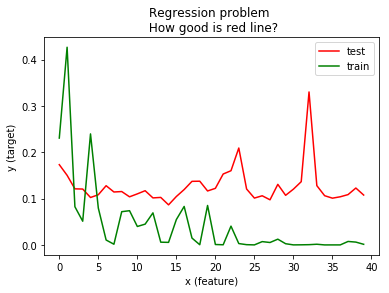

In [9]:
plt.title("Regression problem \n How good is red line?")
plt.xlabel("x (feature)")
plt.ylabel("y (target)")
plt.plot(range(epochs_number), test_loss_plot, color='red', label='test')
plt.plot(range(epochs_number), flattened_train_list, color='green', label='train')
plt.legend()